Installing python modules

In [96]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


# 1. Data cleaning

Loading real estate data into pandas dataframe

In [97]:
df=pd.read_csv("C:\\Users\\vande\\challenge-regression\\data\\real_estate_belgium.csv")

Loading and exploring the data

In [98]:
df.describe()
df.head() # No duplicates and no NAN's 

,Unnamed: 0,longitude,latitude,Postal_Code,Region,Province,Municipality,Price,Price_m2,Type_of_Property,...,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Number_of_Facades,Swimming_Pool,Disabled_Access,Lift
0,0,4.376134,51.248448,2000,2,8,Antwerpen,895000,3129,1,...,0,0,1,30,0,0,2,0,0,0
1,1,4.361370,50.789871,1180,0,0,Uccle,685000,5393,1,...,0,0,1,55,0,0,4,0,0,1
2,3,3.708325,51.003447,9052,2,9,Gent,429210,4292,1,...,0,0,1,12,0,0,3,0,0,1
3,5,4.047008,50.941781,9300,2,9,Aalst,359000,197,0,...,0,0,1,30,1,1700,2,0,0,0
4,7,3.720262,51.053261,9000,2,9,Gent,560000,3684,0,...,0,0,1,23,0,0,2,0,0,1


In [99]:
df.shape

(5989, 25)

# 2: Features engineering

Keep column features which have high correlation coefficients

In [100]:
df = df[["Municipality", "Price", "Living_Area", "Number_of_Rooms", "Fully_Equipped_Kitchen", "Terrace_Area","Garden_Area","Type_of_Property"]]

In [101]:
df.describe()

,Price,Living_Area,Number_of_Rooms,Fully_Equipped_Kitchen,Terrace_Area,Garden_Area,Type_of_Property
count,5.989000e+03,5989.000000,5989.000000,5989.000000,5989.000000,5989.000000,5989.000000
mean,4.023257e+05,131.432960,2.535148,0.278845,19.201870,63.332443,0.690265
std,2.224666e+05,70.267915,1.143061,0.448468,21.059055,234.124841,0.462423
min,3.000000e+04,17.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.490000e+05,86.000000,2.000000,0.000000,7.000000,0.000000,0.000000
50%,3.450000e+05,110.000000,2.000000,0.000000,13.000000,0.000000,1.000000
75%,4.800000e+05,159.000000,3.000000,1.000000,24.000000,0.000000,1.000000
max,1.335000e+06,547.000000,7.000000,1.000000,215.000000,4162.000000,1.000000


# 3: Data formatting

## Create XGBoost regression matrices

In [102]:
# Extract feature and target arrays

X, y = df.drop('Price', axis=1), df[['Price']]

In [103]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [104]:
X.dtypes

Municipality              category
Living_Area                  int64
Number_of_Rooms              int64
Fully_Equipped_Kitchen       int64
Terrace_Area                 int64
Garden_Area                  int64
Type_of_Property             int64
dtype: object

In [105]:
# split dataset into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [106]:
X_train.iloc[:,0:7]

,Municipality,Living_Area,Number_of_Rooms,Fully_Equipped_Kitchen,Terrace_Area,Garden_Area,Type_of_Property
3112,Turnhout,180,2,1,200,1000,1
2457,Asse,290,4,0,32,0,0
3878,Ganshoren,84,3,0,9,0,1
4588,Woluwe-Saint-Lambert,127,2,0,4,0,1
5790,Turnhout,75,2,0,40,0,1
...,...,...,...,...,...,...,...
905,Uccle,200,3,1,20,50,0
5192,Kraainem,82,1,1,25,0,1
3980,Brugge,51,1,0,2,0,1
235,Braine-l'Alleud,68,1,1,19,0,1


In [107]:
# normalize numeric data

X_train['Living_Area'] = np.log2(X_train['Living_Area'])
X_test['Living_Area'] = np.log2(X_test['Living_Area'])
y_train_norm = np.log2(y_train) 
y_test_norm = np.log2(y_test)

In [108]:
# Create regression matrices

dtrain_reg = xgb.DMatrix(X_train, y_train_norm, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test_norm, enable_categorical=True)

## XGBoost regression

### Training data

In [109]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [110]:
# explainer = shap.explainer

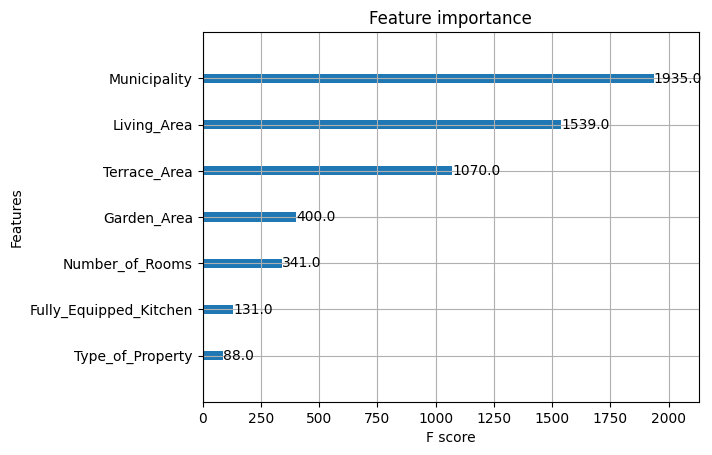

In [111]:
# Plot the feature importances
xgb.plot_importance(model)
plt.show()

### Model evaluation with r², rmse (root mean squared error), and mae (mean absolute error)

In [112]:
# model prediction

preds = model.predict(dtest_reg)

rmse = root_mean_squared_error(y_test, preds)

r2 = r2_score(y_test, preds)

mae = mean_absolute_error(y_test, preds)

print(f"R-squared: {r2:.2f}, RMSE: {rmse:.0f}, MAE: {mae:.0f} for test data in base model.")

R-squared: -3.31, RMSE: 453762, MAE: 397660 for test data in base model.


<module 'matplotlib.pyplot' from 'c:\\Users\\vande\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

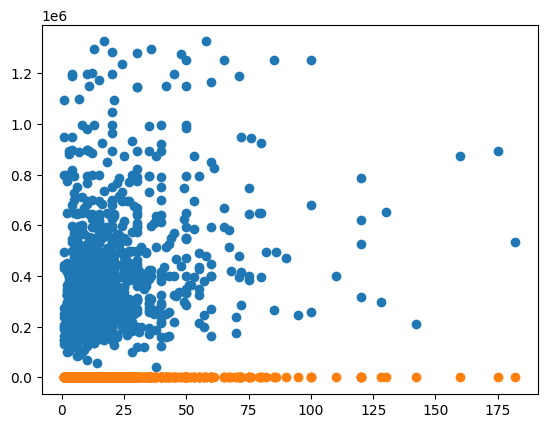

In [113]:
plt.scatter(X_test['Terrace_Area'], y_test)
plt.scatter(X_test['Terrace_Area'], preds)
plt

### Using Validation Sets During Training

In [114]:
# set up the parameters

params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}
n = 100

In [115]:
# setup list of two tuples that each contain two elements. 
# The first element is the array for the model to evaluate, and the second is the array’s name.

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

In [116]:
# pass this array to the evals parameter of xgb.train, we will see the model performance after each boosting round:

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

[0]	train-rmse:0.58201	validation-rmse:0.58604
[10]	train-rmse:0.29889	validation-rmse:0.37535
[20]	train-rmse:0.26898	validation-rmse:0.37277
[30]	train-rmse:0.24498	validation-rmse:0.37507
[40]	train-rmse:0.22550	validation-rmse:0.37704
[50]	train-rmse:0.20626	validation-rmse:0.37929
[60]	train-rmse:0.19406	validation-rmse:0.38127
[70]	train-rmse:0.18060	validation-rmse:0.38155
[80]	train-rmse:0.17053	validation-rmse:0.38356
[90]	train-rmse:0.16083	validation-rmse:0.38523
[99]	train-rmse:0.15522	validation-rmse:0.38545


## XGBoost early stopping

Generally, the more rounds there are, the more XGBoost tries to minimize the loss. 

But this doesn’t mean the loss will always go down. Let’s try with 5000 boosting rounds with the verbosity of 500:

In [117]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}
n = 5000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250 # Every ten rounds
)


[0]	train-rmse:0.58201	validation-rmse:0.58604
[250]	train-rmse:0.08631	validation-rmse:0.39342
[500]	train-rmse:0.04797	validation-rmse:0.40131
[750]	train-rmse:0.03573	validation-rmse:0.40457
[1000]	train-rmse:0.03264	validation-rmse:0.40568
[1250]	train-rmse:0.03240	validation-rmse:0.40587
[1500]	train-rmse:0.03240	validation-rmse:0.40587
[1750]	train-rmse:0.03240	validation-rmse:0.40587
[2000]	train-rmse:0.03240	validation-rmse:0.40587
[2250]	train-rmse:0.03240	validation-rmse:0.40587
[2500]	train-rmse:0.03240	validation-rmse:0.40587
[2750]	train-rmse:0.03240	validation-rmse:0.40587
[3000]	train-rmse:0.03240	validation-rmse:0.40587
[3250]	train-rmse:0.03240	validation-rmse:0.40587
[3500]	train-rmse:0.03240	validation-rmse:0.40587
[3750]	train-rmse:0.03240	validation-rmse:0.40587
[4000]	train-rmse:0.03240	validation-rmse:0.40587
[4250]	train-rmse:0.03240	validation-rmse:0.40587
[4500]	train-rmse:0.03240	validation-rmse:0.40587
[4750]	train-rmse:0.03240	validation-rmse:0.40587
[4999]

We want the golden middle: a model that learned just enough patterns in training that it gives the highest performance on the validation set. So, how do we find the perfect number of boosting rounds, then?

We will use a technique called early stopping. Early stopping forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

This means we can set as high a number of boosting rounds as long as we set a sensible number of early stopping rounds.

In [118]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}
n = 10000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   # Activate early stopping
   early_stopping_rounds = 50

)


[0]	train-rmse:0.58201	validation-rmse:0.58604
[10]	train-rmse:0.29889	validation-rmse:0.37535
[20]	train-rmse:0.26898	validation-rmse:0.37277
[30]	train-rmse:0.24498	validation-rmse:0.37507
[40]	train-rmse:0.22550	validation-rmse:0.37704
[50]	train-rmse:0.20626	validation-rmse:0.37929
[60]	train-rmse:0.19406	validation-rmse:0.38127
[69]	train-rmse:0.18152	validation-rmse:0.38154


## XGBoost Cross-Validation

Since we try to find the best value of a hyperparameter by comparing the validation performance of the model on the test set, 
we will end up with a model that is configured to perform well only on that particular test set. 

Instead, we want a model that performs well across the board — on any test set we throw at it.

A possible workaround is splitting the data into three sets. The model trains on the first set, the second set is used for evaluation and hyperparameter tuning, and the third is the final one we test the model before production.

But when data is limited, splitting data into three sets will make the training set sparse, which hurts model performance.

The solution to all these problems is cross-validation. In cross-validation, we still have two sets: training and testing.

In [119]:
# While the test set waits in the corner, we split the training into 3, 5, 7, or k splits or folds. 
# Then, we train the model k times. Each time, we use k-1 parts for training and the final kth part for validation. 
# This process is called k-fold cross-validation:

params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n, 
   nfold=5, # specify the number of splits
   early_stopping_rounds=20
)

In [120]:
# It has the same number of rows as the number of boosting rounds. 

# Each row is the average of all splits for that round. So, to find the best score, we take the minimum of the test-rmse-mean column:

best_rmse = results['test-rmse-mean'].min()

print(best_rmse)

0.3798108424459921


In [121]:
# model prediction

preds = model.predict(dtest_reg)

rmseTest = root_mean_squared_error(y_test, preds)

r2Test = r2_score(y_test, preds)

maeTest = mean_absolute_error(y_test, preds)

print(f"R-squared: {r2Test:.2f}, RMSE: {rmseTest:.0f}, MAE: {maeTest:.0f} for test data in base model.")

R-squared: -3.31, RMSE: 453762, MAE: 397660 for test data in base model.


In [122]:
y_test.size

1198

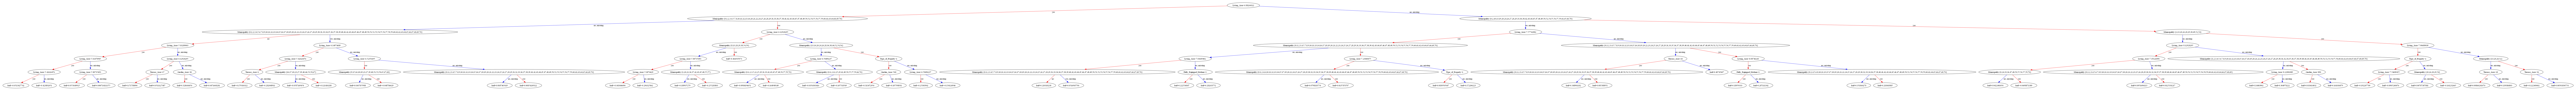

In [123]:
# plot tree
xgb.plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
plt.show()

<Axes: >

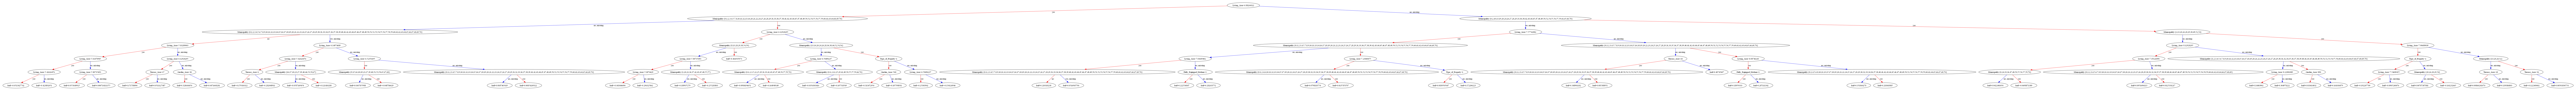

In [124]:
fig, ax = plt.subplots(figsize=(150, 30))
xgb.plot_tree(model, ax=ax)